# Exploratory Data Analysis
---
In this notebook I will investigate the data looking for possible problems, class balance and interesting correlations.

### Table of contents
- [Setup](#setup)

## Setup <a name='setup'></a>

In [177]:
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark as ps
import pyspark.sql.functions as psf
import warnings

from scipy import stats
from pyspark.sql.types import IntegerType, ArrayType, StringType, FloatType
from pyspark.ml.feature import RegexTokenizer, IDF, CountVectorizer, StopWordsRemover
from pyspark.ml import Pipeline

warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext sql_magic

sns.set(font_scale=1.2)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

The sql_magic extension is already loaded. To reload it, use:
  %reload_ext sql_magic


In [77]:
@psf.udf(ArrayType(StringType()))
def remove_empyt_doc(tokens):
    '''
    Convert [''] into an empty list.
    '''
    if tokens == ['']:
        return []
    else:
        return tokens

In [78]:
spark = ps.sql.SparkSession.builder\
                            .master('local[6]')\
                            .config('spark.driver.memory', '8g')\
                            .appName('eda')\
                            .getOrCreate()

In [79]:
# configure sql magic to use the spark session as the client
%config SQL.conn_name = 'spark'
%config SQL.output_result = False
%config SQL.notify_result = False

Before, starting with any analysis I will load the data and create a temporary view.

In [80]:
amazon = spark.read.parquet('../data/amazon.parquet')

## Splitting the data

Before proceeding with the analysis, I want to split the data into train and test sets so I am unbiased as possible. In the next sections, I intend to further break down the train set into training and development sets.
- __Train__: The training set is used to train the final machine learning model and exploration if necessary.
- __Dev__: The development set is a smaller data set used to rapidly iterate through models using cross validation.
- __Test__: Also known as a holdout set, the test set serves the purpose of validating the final model trained on the training set.

With that said, it is a good idea to checkout how many entries we have at our disposal so we can plan the size of each set.

__Obs.:__ The class balance of the test set will not be modified as it is meant to represent new unseen data.

In [81]:
n_entries = amazon.count()
print(f"Number of entries: {n_entries:,.0f}")

Number of entries: 33,282,097


A `test` set of 100k entries should be more than enough and a 500k for the `dev` set should be plenty.

In [82]:
test_size = 1e5
dev_size = 5e5
train_size = n_entries - test_size - dev_size
train, dev, test = amazon.randomSplit([train_size, dev_size, test_size], seed=42)

## Class balance

One of the biggest advantages of using PySpark is the flexibility that comes with it in term of querying. PySpark's data frame abstraction allows the user to freely alternate between declarative and imperative querying paradigms.

In [83]:
train.createOrReplaceTempView('train')

Since we are framing the our problem as a sentiment classification problem, understanding the distribution of a classes is fundamental for the model's success.

In [84]:
%%read_sql classes
SELECT rating, COUNT(*) as counts
FROM train
GROUP BY rating
ORDER BY rating;

Query started at 12:27:04 PM UTC; Query executed in 0.86 m

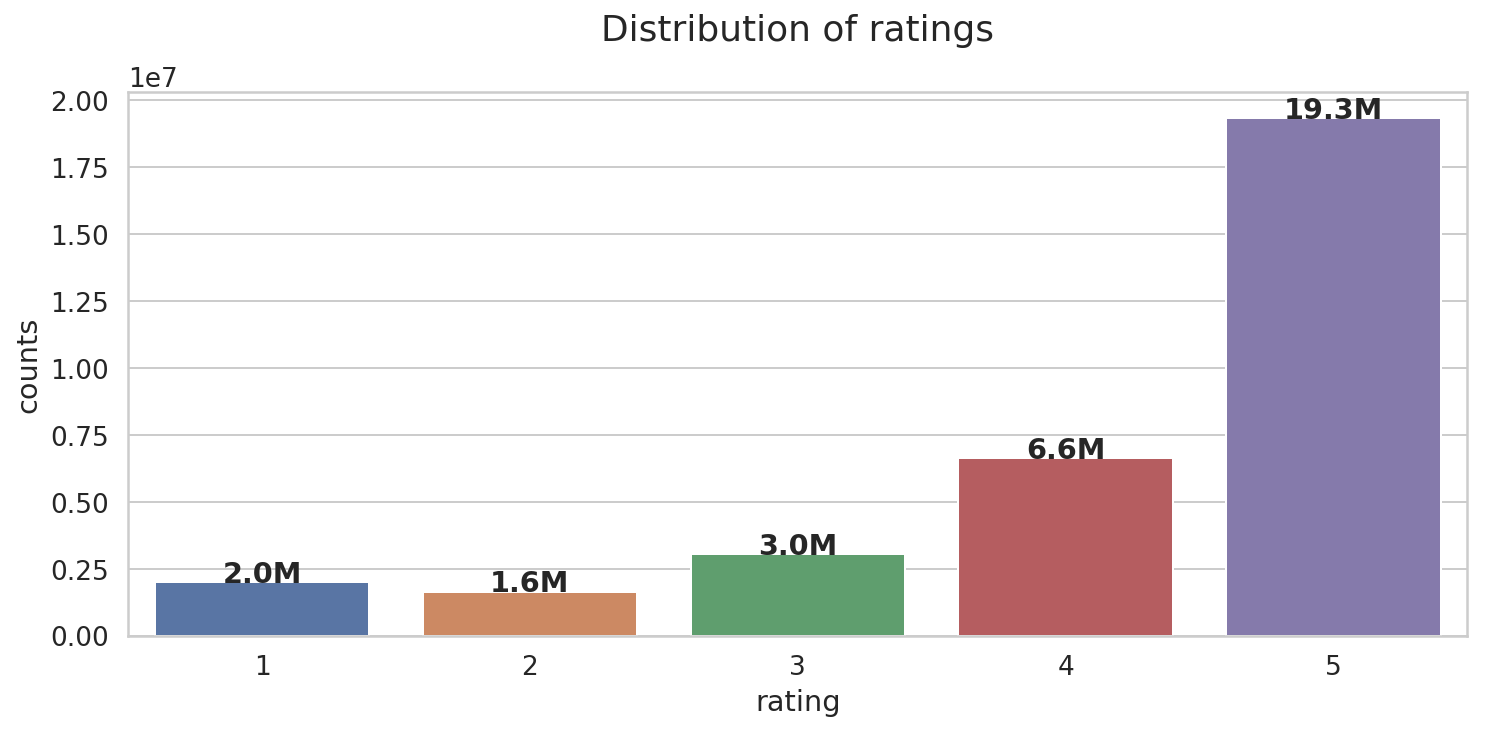

In [85]:
fig = plt.figure()
ax = plt.gca()

sns.barplot(x='rating', y='counts', data=classes, ax=ax)

# add the values to the top of the bars
for _, (rating, count) in classes.iterrows():
    ax.text(
        rating - 1,
        count,
        f'{count/1e6:.1f}M',
        horizontalalignment='center',
        fontweight='bold'
    )

ax.set_title("Distribution of ratings\n", fontsize=18)
plt.show()

Wow! That is what I call a imbalanced dataset! Certainly such skewed distribution will be taken into account when training the model and evaluation the results.

Another big concern when it comes to training and the models is the length of the reviews. If too short, they might not carry enough information to allow for any classification. Let's checkout the distribution of reviews' lengths (using a sample).

In [86]:
# remove white spaces leading and trailing the documents
trimmed_reviews = psf.trim(dev['review'])

# split the docs into tokens white spaces as delimiters
tokens = psf.split(trimmed_reviews, r' +')

# remove empty strings from ['']
clean_tokens = remove_empyt_doc(tokens)

# count the number of element in the token lists
review_length = psf.size(clean_tokens).alias('review_length')

# create split the reviews as high rating and not high rating
rating_qual = (dev['rating'] > 3).alias('high_rating')

review_lengths = dev.select(rating_qual, review_length).toPandas()

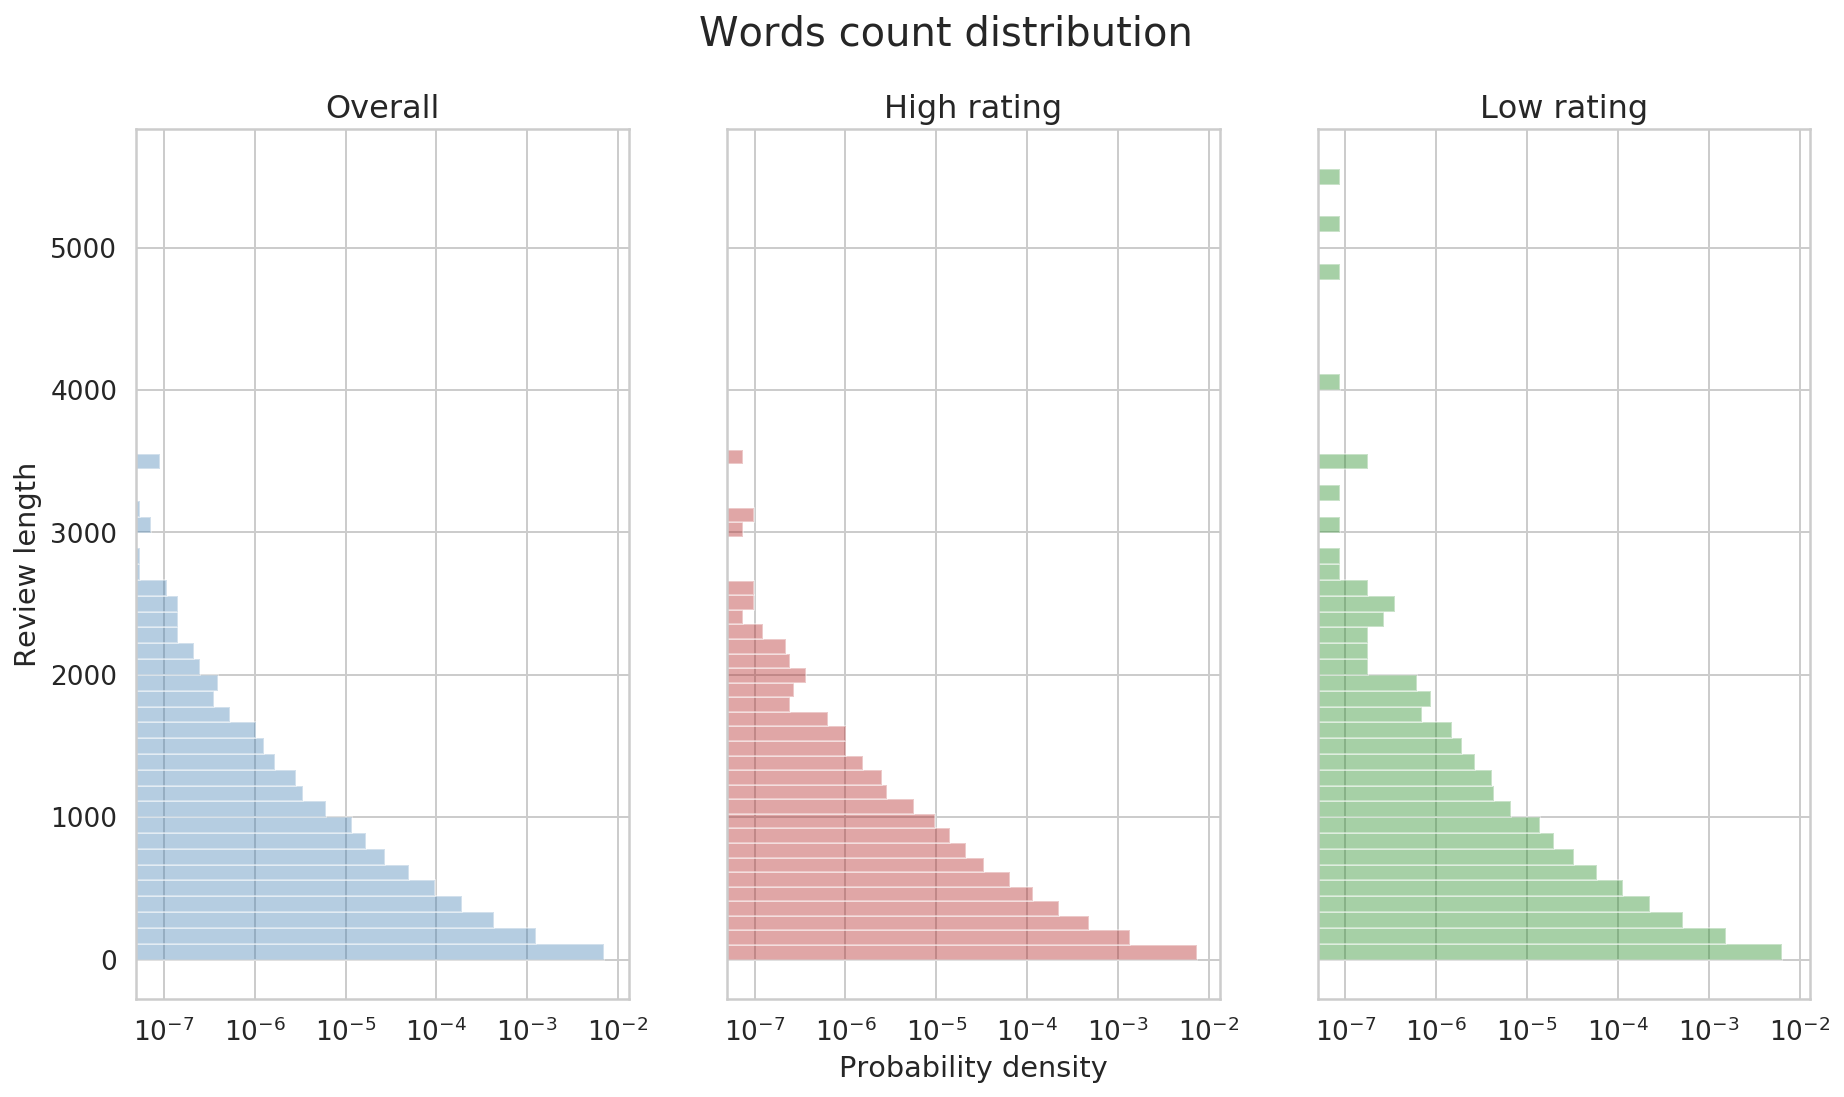

In [151]:
fig, axs = plt.subplots(1, ncols=3, sharey=True, sharex=True, figsize=(15, 8))

settings = [
    {
        'mask': review_lengths.index,
        'title': 'Overall',
        'color': 'steelblue'
    },
    {
        'mask': review_lengths['high_rating'],
        'title': 'High rating',
        'color': 'firebrick'
    },
    {
        'mask': ~review_lengths['high_rating'],
        'title': 'Low rating',
        'color': 'forestgreen'
    }
]

for ax, sets in zip(axs, settings):
    sns.distplot(
        review_lengths.loc[sets['mask'], 'review_length'],
        vertical=True,
        norm_hist=True,
        kde=False,
        ax=ax,
        color=sets['color']
    )
    ax.set_title(sets['title'], fontsize=16)
    ax.set_xscale('log')
    ax.set_ylabel('')
    
axs[0].set_ylabel('Review length')
axs[1].set_xlabel('Probability density')

fig.suptitle('Words count distribution', fontsize=20)
fig.set_tight_layout(None)

In [88]:
review_lengths.describe()

,review_length
count,499778.000000
mean,93.742516
std,129.568817
min,0.000000
25%,28.000000
50%,49.000000
75%,104.000000
max,5554.000000


Once again the distribution is very skewed and contains a lot of very short reviews.

Also, there doesn't seem to have a lot of difference between the distributions of reviews with high and low ratings.

Well, let's take a look at some of those reviews with low word counts.

In [89]:
short_reviews = dev.select('review', review_length)\
                        .where(review_length.between(1, 5))\
                        .limit(50)\
                        .toPandas()

In [90]:
short_reviews

,review,review_length
0,Fabulous! Intriguing story well told.,5
1,Great,1
2,it is ok,3
3,GOOD BOOK,2
4,its ok,2
5,What's to be expected,4
6,works fantastic,2
7,cute and fun,3
8,Interesting read for female athletes.,5
9,Good fragance,2


Interestingly enough, short reviews seem to carry a lot of sentiment. Now that I think about it, that makes sense, but I was expecting such behavior at first.

I need to drop the zero length reviews on the other hand, for obvious reasons.

Now, let's see if the lexical diversity can give us any clues of the rating.

In [148]:
@psf.udf(FloatType())
def compute_lexical_diversity(array):
    if not array:
        return None
    n_tokens= len(array)
    n_distinct = len(set(array))
    return n_distinct/n_tokens

In [159]:
review_lower = psf.lower(psf.col('review'))
tokens = psf.split(review_lower, r' +')
tokens_clean = remove_empyt_doc(tokens)
lex_diversity = compute_lexical_diversity(tokens_clean).alias('lexical_diversity')
rating_qual = (psf.col('rating') > 3).alias('high_rating')


lex = dev.select(lex_diversity, rating_qual).toPandas()
lex.dropna(inplace=True)

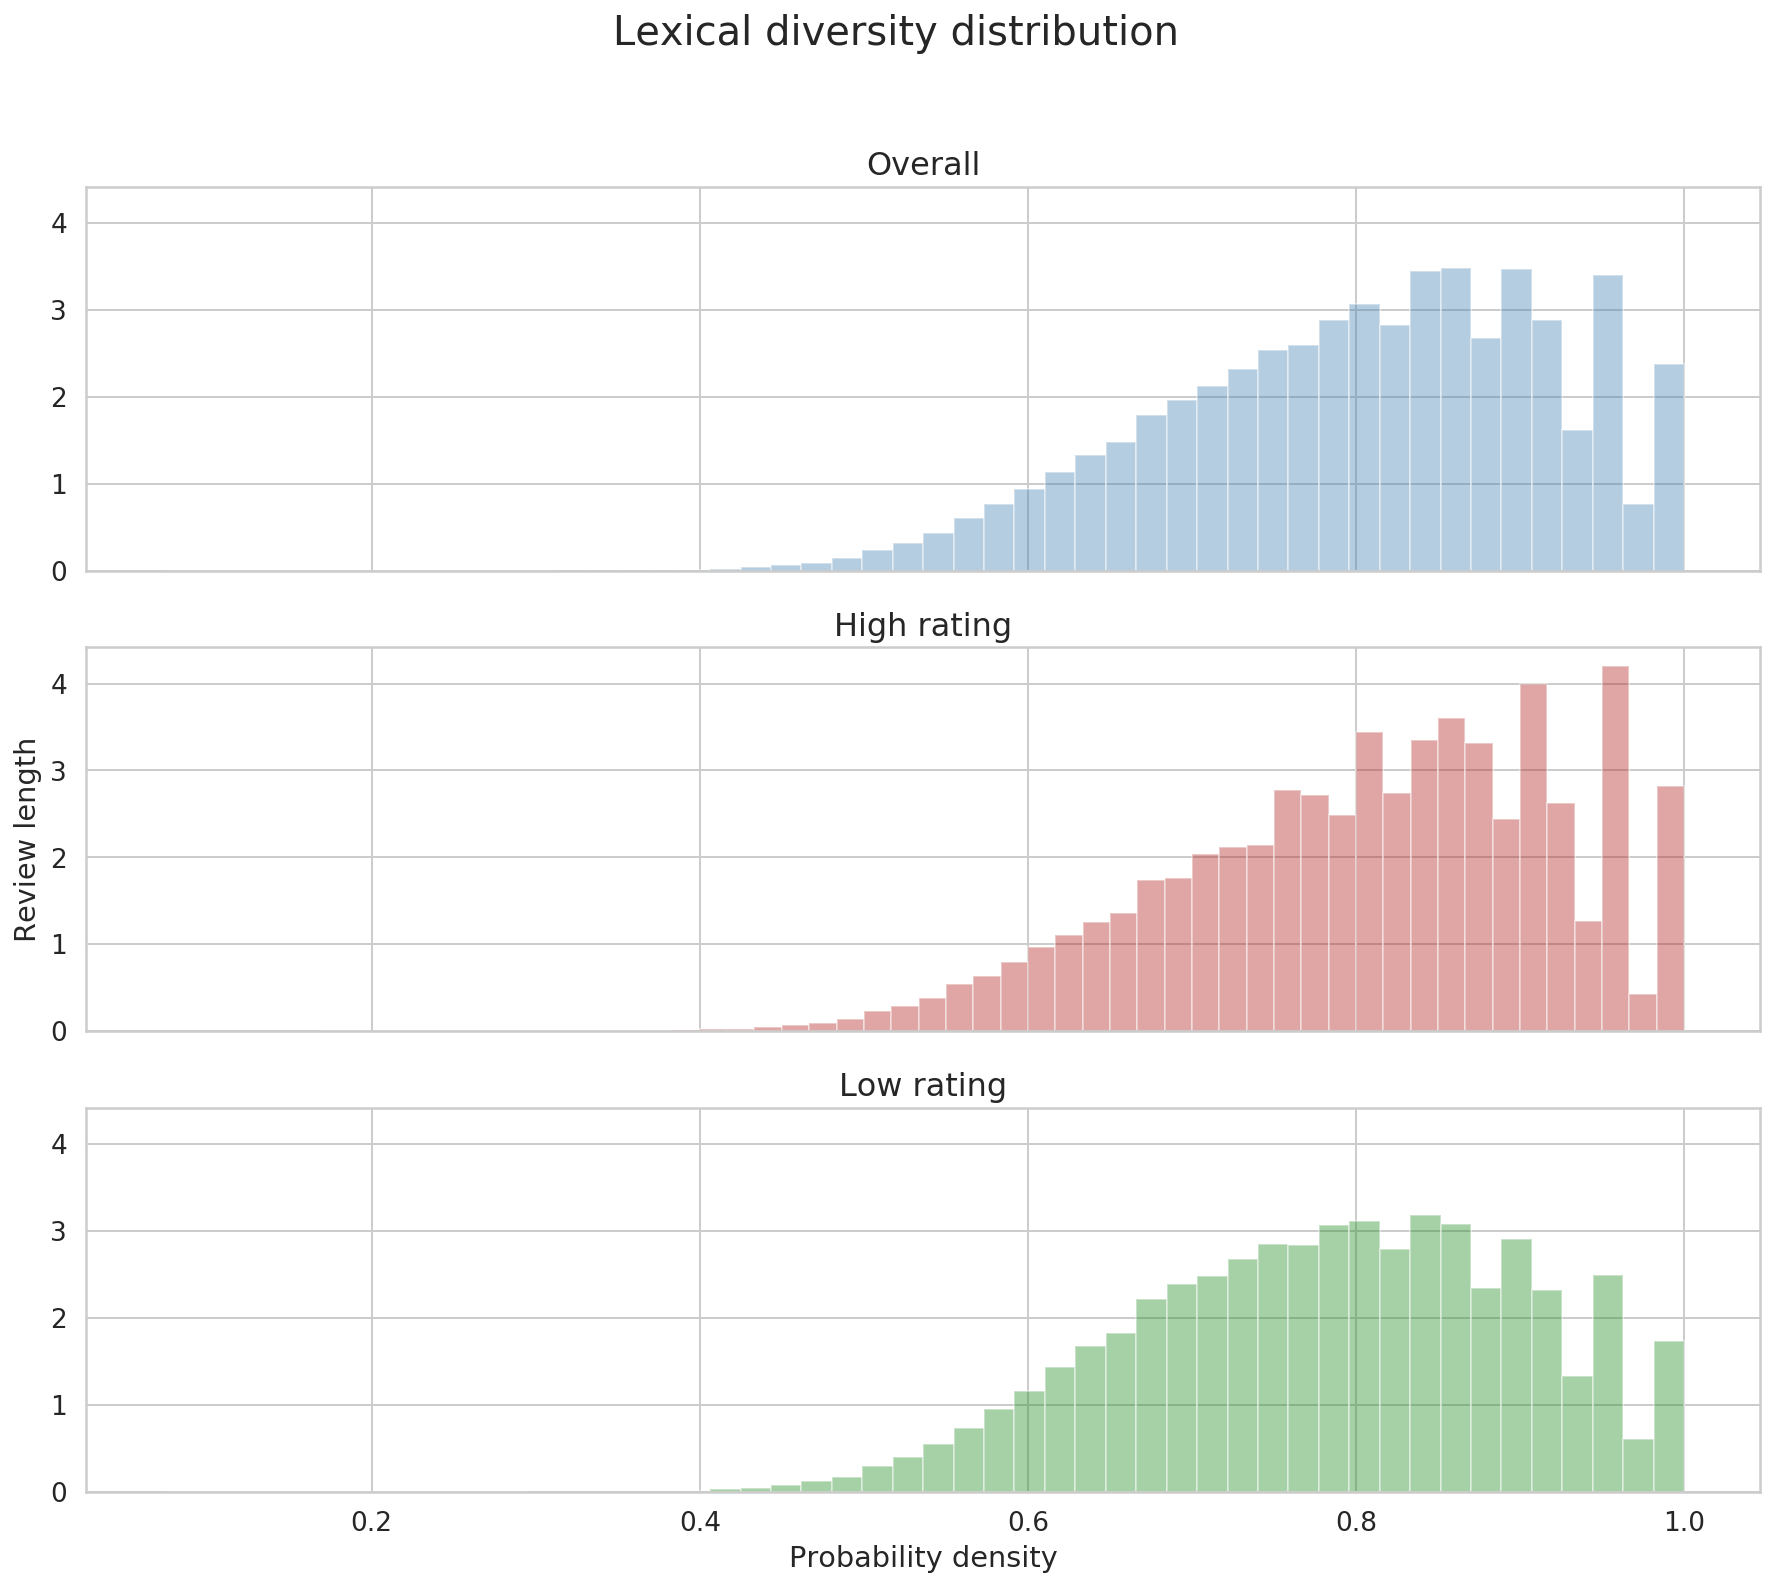

In [176]:
fig, axs = plt.subplots(3, 1, sharey=True, sharex=True, figsize=(15, 12))

settings = [
    {
        'mask': lex.index,
        'title': 'Overall',
        'color': 'steelblue'
    },
    {
        'mask': lex['high_rating'],
        'title': 'High rating',
        'color': 'firebrick'
    },
    {
        'mask': ~lex['high_rating'],
        'title': 'Low rating',
        'color': 'forestgreen'
    }
]

for ax, sets in zip(axs, settings):
    sns.distplot(
        lex.loc[sets['mask'], 'lexical_diversity'],
        vertical=False,
        norm_hist=True,
        kde=False,
        ax=ax,
        color=sets['color']
    )
    ax.set_title(sets['title'], fontsize=16)
    ax.set_ylabel('')
    ax.set_xlabel('')
    
axs[1].set_ylabel('Review length')
axs[2].set_xlabel('Probability density')

fig.suptitle('Lexical diversity distribution', fontsize=20)
fig.set_tight_layout(None)

In [184]:
lex_high = lex.loc[lex['high_rating'], 'lexical_diversity']
lex_low = lex.loc[~lex['high_rating'], 'lexical_diversity']

stats.ks_2samp(lex_high, lex_low)

Ks_2sampResult(statistic=0.09791755381084905, pvalue=0.0)

In [97]:
temp[0]['tokens']

['This',
 'book',
 'hits',
 'the',
 'mark',
 'as',
 'interesting',
 'and',
 'easy',
 'to',
 'read.',
 'The',
 'pictures',
 'are',
 'a',
 'bonus',
 'for',
 'any',
 'Christie',
 'fan.']